# Time-ahead Prediction Accuracy

In this notebook I hope to illustrate the differences between naive day/week/month/year-ahead prediction accuracies.

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tscv import GapRollForward
from tqdm.notebook import tqdm
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv('../data/merged_interpolated.csv')
df.datetime = df.datetime.astype('datetime64')
df.head()

,datetime,tempc,cloud8,windk,wdir,humid,rainmm,radkjm2,pv_est,net_load,total_load
0,2018-03-06 09:30:00,20.75,2.5,14.5,135.0,44.5,0.0,1915.0,318.991,1288,1136.79
1,2018-03-06 10:00:00,21.50,1.0,16.0,140.0,40.0,0.0,2340.0,375.231,1237,1054.87
2,2018-03-06 10:30:00,22.25,1.5,15.5,145.0,37.0,0.0,2570.0,430.909,1189,1002.35
3,2018-03-06 11:00:00,23.00,2.0,15.0,150.0,34.0,0.0,2800.0,485.129,1150,971.54
4,2018-03-06 11:30:00,23.55,2.0,13.0,145.0,32.0,0.0,2945.0,523.989,1122,943.68


Expand datetime feature to its various component parts, plus day of week and week of year.

In [3]:
dt = df['datetime'].astype('datetime64[ns]').dt
df['year'] = dt.year
df['month'] = dt.month
df['day'] = dt.day
df['hour'] = dt.hour
df['minute'] = dt.minute
df['day_of_week'] = dt.day_of_week
df['week'] = dt.isocalendar().week
df.dtypes

datetime       datetime64[ns]
tempc                 float64
cloud8                float64
windk                 float64
wdir                  float64
humid                 float64
rainmm                float64
radkjm2               float64
pv_est                float64
net_load                int64
total_load            float64
year                    int64
month                   int64
day                     int64
hour                    int64
minute                  int64
day_of_week             int64
week                   UInt32
dtype: object

Select training features and extract training matrix X and response y.

In [4]:
X_inds = list(range(1, 8)) + list(range(11, 18))
y_ind = 9
X = df.iloc[:, X_inds].to_numpy()
y = df.iloc[:, 9].to_numpy()

print(X.shape, y.shape)
df.columns[X_inds], df.columns[y_ind]

(87726, 14) (87726,)


(Index(['tempc', 'cloud8', 'windk', 'wdir', 'humid', 'rainmm', 'radkjm2',
        'year', 'month', 'day', 'hour', 'minute', 'day_of_week', 'week'],
       dtype='object'),
 'net_load')

Cross-validation splits are done in an appropriate time-series fashion, with one observation-year (48 observations \* 365 days) for each training set and test set. There should be a good number of splits with a roll size (gap between successive training set starting points) of 30 days.

In [5]:
obs_year = 48*365
tscv = GapRollForward(min_train_size=obs_year, max_train_size=obs_year,
                      min_test_size=obs_year, max_test_size=obs_year,
                      roll_size=48*30)
n_splits = sum(1 for i in tscv.split(df)) # getting length of a generator

print('Number of models to be trained:', n_splits)

Number of models to be trained: 37


Training of each forest is parallelised to save time, but even so the full training takes a few minutes. No hyperparameters are selected or tuned. Models and their last training observation's timestamp are saved to a new dataframe.

In [6]:
#warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
models, train_ends = [], []

for i, (train_ind, test_ind) in tqdm(enumerate(tscv.split(df))):
    X_train, X_test = df.iloc[train_ind, X_inds], df.iloc[test_ind, X_inds]
    y_train, y_test = df.iloc[train_ind, y_ind], df.iloc[test_ind, y_ind]

    rf = RandomForestRegressor(n_jobs=8)
    rf.fit(X_train, y_train)
    models.append(rf)
    train_ends.append(df.loc[train_ind[-1], 'datetime'])

preds = pd.DataFrame({'train_end': train_ends})
print(len(models), preds.shape)
preds.head()

0it [00:00, ?it/s]

37 (37, 1)


,train_end
0,2019-03-06 09:00:00
1,2019-04-05 09:00:00
2,2019-05-05 09:00:00
3,2019-06-04 09:00:00
4,2019-07-04 09:00:00


Based on each model's last training observation timestamp, day/week/month/year-ahead timestamps are computed and added to the dataframe. True net load values are then joined using those timestamps.

In [7]:
offsets = {
    'day': pd.DateOffset(days=1),
    'week': pd.DateOffset(weeks=1),
    'month': pd.DateOffset(months=1),
    'year': pd.DateOffset(years=1)
}
for k, v in offsets.items():
    dt_name = k+'_DT'
    preds[dt_name] = preds['train_end'] + v
    preds = preds.merge(df[['datetime', 'net_load']], how='inner', left_on=dt_name, 
                        right_on='datetime', validate='one_to_one')
    preds.drop('datetime', axis=1, inplace=True)
    preds.rename(columns={'net_load': k+'_true'}, inplace=True)

preds.head()

,train_end,day_DT,day_true,week_DT,week_true,month_DT,month_true,year_DT,year_true
0,2019-03-06 09:00:00,2019-03-07 09:00:00,1244,2019-03-13 09:00:00,1295,2019-04-06 09:00:00,1304,2020-03-06 09:00:00,1388
1,2019-04-05 09:00:00,2019-04-06 09:00:00,1304,2019-04-12 09:00:00,1395,2019-05-05 09:00:00,1104,2020-04-05 09:00:00,1134
2,2019-05-05 09:00:00,2019-05-06 09:00:00,1480,2019-05-12 09:00:00,1275,2019-06-05 09:00:00,1964,2020-05-05 09:00:00,1502
3,2019-06-04 09:00:00,2019-06-05 09:00:00,1964,2019-06-11 09:00:00,1718,2019-07-04 09:00:00,1922,2020-06-04 09:00:00,1902
4,2019-07-04 09:00:00,2019-07-05 09:00:00,1856,2019-07-11 09:00:00,1783,2019-08-04 09:00:00,1407,2020-07-04 09:00:00,1564


Net load values are predicted for each model and offset and added as new columns.

In [8]:
dt_colnames = [x+'_DT' for x in offsets]
pred_colnames = [x+'_pred' for x in offsets]

# silence warning about missing colnames in X
warnings.filterwarnings("ignore", category=UserWarning)
for i, rf in enumerate(models):
    X_offsets = X[df['datetime'].isin(preds.loc[i, dt_colnames]), :]
    preds.loc[i, pred_colnames] = rf.predict(X_offsets)
preds.head()

,train_end,day_DT,day_true,week_DT,week_true,month_DT,month_true,year_DT,year_true,day_pred,week_pred,month_pred,year_pred
0,2019-03-06 09:00:00,2019-03-07 09:00:00,1244,2019-03-13 09:00:00,1295,2019-04-06 09:00:00,1304,2020-03-06 09:00:00,1388,1356.18,1355.08,1130.30,1418.08
1,2019-04-05 09:00:00,2019-04-06 09:00:00,1304,2019-04-12 09:00:00,1395,2019-05-05 09:00:00,1104,2020-04-05 09:00:00,1134,1127.85,1370.33,1128.73,1151.07
2,2019-05-05 09:00:00,2019-05-06 09:00:00,1480,2019-05-12 09:00:00,1275,2019-06-05 09:00:00,1964,2020-05-05 09:00:00,1502,1517.07,1155.24,1907.40,1457.27
3,2019-06-04 09:00:00,2019-06-05 09:00:00,1964,2019-06-11 09:00:00,1718,2019-07-04 09:00:00,1922,2020-06-04 09:00:00,1902,1932.38,1523.08,1866.06,1819.24
4,2019-07-04 09:00:00,2019-07-05 09:00:00,1856,2019-07-11 09:00:00,1783,2019-08-04 09:00:00,1407,2020-07-04 09:00:00,1564,1638.90,1705.74,1472.77,1403.15


Now calculate percentage errors for each offset's true vs predicted values. Also reorder columns for a nicer final view.

In [9]:
def pe(y_true, y_pred):
    epsilon = np.finfo(np.float64).eps
    return np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), epsilon)

for x in offsets:
    preds[x+'_pe'] = pe(preds[x+'_true'], preds[x+'_pred'])

colnames = sorted(preds.columns)
colnames.remove('train_end')
colnames.insert(0, 'train_end')
preds = preds.reindex(colnames, axis=1)
preds.head()

,train_end,day_DT,day_pe,day_pred,day_true,month_DT,month_pe,month_pred,month_true,week_DT,week_pe,week_pred,week_true,year_DT,year_pe,year_pred,year_true
0,2019-03-06 09:00:00,2019-03-07 09:00:00,0.090177,1356.18,1244,2019-04-06 09:00:00,0.133206,1130.30,1304,2019-03-13 09:00:00,0.046394,1355.08,1295,2020-03-06 09:00:00,0.021671,1418.08,1388
1,2019-04-05 09:00:00,2019-04-06 09:00:00,0.135084,1127.85,1304,2019-05-05 09:00:00,0.022400,1128.73,1104,2019-04-12 09:00:00,0.017685,1370.33,1395,2020-04-05 09:00:00,0.015053,1151.07,1134
2,2019-05-05 09:00:00,2019-05-06 09:00:00,0.025047,1517.07,1480,2019-06-05 09:00:00,0.028819,1907.40,1964,2019-05-12 09:00:00,0.093929,1155.24,1275,2020-05-05 09:00:00,0.029780,1457.27,1502
3,2019-06-04 09:00:00,2019-06-05 09:00:00,0.016100,1932.38,1964,2019-07-04 09:00:00,0.029105,1866.06,1922,2019-06-11 09:00:00,0.113458,1523.08,1718,2020-06-04 09:00:00,0.043512,1819.24,1902
4,2019-07-04 09:00:00,2019-07-05 09:00:00,0.116972,1638.90,1856,2019-08-04 09:00:00,0.046745,1472.77,1407,2019-07-11 09:00:00,0.043331,1705.74,1783,2020-07-04 09:00:00,0.102845,1403.15,1564


Finally, print MAPE and show boxplot for each offset.

day_pe      0.113944
week_pe     0.099598
month_pe    0.089728
year_pe     0.102651
dtype: float64


<Axes: >

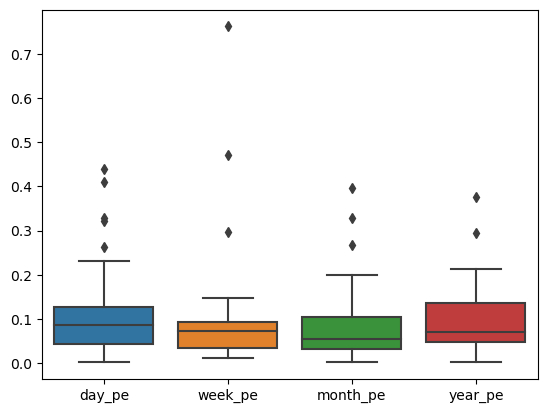

In [10]:
pe_cols = [x+'_pe' for x in offsets]
print(preds[pe_cols].mean())
sns.boxplot(preds[pe_cols])